<h1><center>Comparative Analysis SP vs μP</center></h1>

# Introduction
In this notebook, we explore the differences between Standard Parametrization (SP) and Maximal Update Parametrization (μP) in the context of training neural networks. We aim to understand how μP affects the training process, and if it offers any advantages over traditional methods.

The key focal point of this analysis is to validate the hypothesis that *Wider is always better* under the μP framework and to demonstrate the hyperparameter stability that μP claims to offer.

This will be demonstrated using a case study with the well-known CIFAR10 dataset.

For those interested in diving deeper, here are the links to the original paper and code repository:
- **Article**: [Understanding the Role of Training Regimes in Continual Learning](https://arxiv.org/abs/2203.03466)
- **Code**: [Microsoft's μP GitHub Repository](https://github.com/microsoft/mup)

# Plan
1. Setup and Preliminaries
2. Data Preparation
3. Defining the Models
4. Training Loop and Weight Tracking
5. Analysis of Results



# Setup: Importing Necessary Libraries
Before we begin, we need to import the necessary libraries and set up our environment.

In [1]:
!pip -q install mup

  Preparing metadata (setup.py) ... done


In [2]:
import time
import math
import numpy as np
import seaborn as sns
import pandas as pd

# PyTorch and related imports for deep learning.
import torch  # Main PyTorch library.
from torch import nn  # Provides building blocks for neural network layers.
from torch.optim import SGD  # Contains optimizers such as SGD for training models.
import torch.nn.functional as F  # Functional interface for operations like activation functions.
from torchvision import datasets, transforms  # Utilities for working with image datasets and transformations.

# Imports from the mup package for working with Maximal Update Parametrization (μP).
from mup import MuSGD, get_shapes, set_base_shapes, make_base_shapes, MuReadout  # for μP and model adaptation.

# Setting Up the Training Parameters

We need to define a few key parameters and hyperparameters (HPs). They play important roles in determining the efficiency and effectiveness of the training process. This includes :


- **`batch_size`**: The number of training examples utilized in one iteration. A larger batch size provides a more accurate estimate of the gradient, but requires more memory. Conversely, a smaller batch size may lead to faster training but with a less stable convergence.

- **`epochs`**: An epoch represents one full cycle through the entire training dataset. More epochs mean the model has more chances to learn and adjust its weights but also risks overfitting if too many epochs are used without proper regularization.

- **`nonlin`**: Stands for the nonlinear activation function used in the neural network layers. Activation functions like ReLU (Rectified Linear Unit) introduce non-linearity, helping the model learn complex patterns.

- **`criterion`**: Refers to the loss function used to evaluate the difference between the model's predictions and the actual targets. Cross-entropy loss is commonly used for classification tasks.

- **`data_dir`**: The directory where training and validation data are stored.

- **`base_shapes_path`**: In the context of Maximal Update Parametrization (μP), this path points to the file containing base shape information necessary for applying μP to a model. This parametrization technique adjusts the model's architecture dynamically.

- **`list_widths`**: This is a list of model widths to experiment with. Width here typically refers to the dimensionality of the layers within the model ( number of neurons in a layer)

- **`torch.manual_seed(1)`**: Setting the random seed ensures that the training process is reproducible. This means that the random numbers generated will be the same on every run, making it easier to debug or compare models.

- **`device`**: Specifies the device on which to perform training, such as a CPU or GPU. Training on a GPU (`cuda`) is significantly faster than on a CPU for most deep learning tasks.

- **`kwargs`**: This dictionary contains additional arguments for the `DataLoader`, such as `num_workers`, which determines how many subprocesses to use for data loading, and `pin_memory`, which can improve transfer rates to CUDA devices.


In [3]:
batch_size = 64 # Batch size for data processing.
epochs = 5 # Total training epochs.
nonlin = torch.relu # Activation function.
criterion = F.cross_entropy # Loss calculation criterion.
data_dir = '/tmp' # Directory for data storage.
base_shapes_path = './demo_width256.bsh' # Path to the base shapes file. This is required for applying the μP technique.
list_widths = [256, 512, 1024, 2048, 4096, 8192] # Different model widths to evaluate.

torch.manual_seed(1)
device = torch.device("cuda")
kwargs = {'num_workers': 1, 'pin_memory': True}

# Data processing
To train our models, we need to load and preprocess the CIFAR10 dataset. This involves normalization, splitting the data, and creating data loaders.

In [4]:
# Define a transformation sequence to preprocess the images.
transform = transforms.Compose([
    transforms.ToTensor(),  # Converts images into PyTorch tensors with pixel values in [0, 1].
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalizes tensor with mean and std; centers around [0, 0, 0].
])

# Load the CIFAR10 training dataset.
# 'root' specifies the directory for storing the dataset.
# 'train=True' indicates that we are loading the training portion of the dataset.
# 'download=True' allows for automatic download if the data is not present at 'root'.
# 'transform=transform' applies the preprocessing defined above to each image.
trainset = datasets.CIFAR10(root=data_dir, train=True, download=True, transform=transform)

# DataLoader for batching, shuffling, and loading the training data in parallel using 'num_workers'.
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

# Load the CIFAR10 testing dataset, similar to the training set but with 'train=False' to load the test set.
testset = datasets.CIFAR10(root=data_dir, train=False, download=True, transform=transform)

# DataLoader for the test data. Set 'shuffle=False' as the order doesn't matter for testing.
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)


100%|██████████| 170498071/170498071 [00:03<00:00, 49024464.16it/s]


Extracting /tmp/cifar-10-python.tar.gz to /tmp
Files already downloaded and verified


# Model definitions
Here, we define two models: one with standard parametrization and another with μP. These models will be used to compare the training dynamics of SP and μP.

A simple MLP without biases.
We expose a few hyperparameters for further tuning: input/output multiplier and initialization standard deviation.

In [5]:
# Defining the SP - model :  a Multilayer Perceptron (MLP) class with customizable parameters.

class MLP(nn.Module):
    def __init__(self, width=128, num_classes=10, nonlin=F.relu, output_mult=1.0, input_mult=1.0):
        super(MLP, self).__init__()
        # Activation function and scaling factors for inputs/outputs.
        self.nonlin = nonlin
        self.input_mult = input_mult
        self.output_mult = output_mult
        # Define layers with specified width and no biases.
        self.fc_1 = nn.Linear(3072, width, bias=False)
        self.fc_2 = nn.Linear(width, width, bias=False)
        self.fc_3 = nn.Linear(width, num_classes, bias=False)
        # Initialize weights.
        self.reset_parameters()

    # Weight initialization and scaling.
    def reset_parameters(self):
        # He (Kaiming) initialization for maintaining variance through layers.
        nn.init.kaiming_normal_(self.fc_1.weight, a=1, mode='fan_in')
        # Scale the first layer weights.
        self.fc_1.weight.data /= self.input_mult**0.5
        nn.init.kaiming_normal_(self.fc_2.weight, a=1, mode='fan_in')
        # Zero initialization for the final layer weights.
        nn.init.zeros_(self.fc_3.weight)

    # Forward pass
    def forward(self, x):
        out = self.nonlin(self.fc_1(x) * self.input_mult**0.5)
        out = self.nonlin(self.fc_2(out))
        return self.fc_3(out) * self.output_mult

In [6]:
class MLP(nn.Module):
    """
    Multilayer Perceptron for image classification.

    Architecture:
    Input --> Linear(3072, width) --> ReLU --> Linear(width, width) --> ReLU --> Linear(width, num_classes)
    """

    def __init__(self, width=128, num_classes=10, nonlin=F.relu, output_mult=1.0, input_mult=1.0):
        """
        Initializes the MLP model.

        Parameters:
        - width: Number of neurons in the hidden layers.
        - num_classes: Number of output classes for classification.
        - nonlin: Non-linear activation function (ReLU by default).
        - output_mult: Scaling factor for the output layer.
        - input_mult: Scaling factor for the input layer.
        """
        super(MLP, self).__init__()

        # Activation function for introducing non-linearity
        self.nonlin = nonlin

        # Scaling factors for inputs and outputs
        self.input_mult = input_mult
        self.output_mult = output_mult

        # First layer takes 3072 inputs (e.g., flattened CIFAR-10 images) and outputs 'width' features, no bias
        self.fc_1 = nn.Linear(3072, width, bias=False) # 3072 = 32 (width) * 32 (height) * 3 (channels)


        # Second layer: width to width
        self.fc_2 = nn.Linear(width, width, bias=False)

        # Final layer outputs 'num_classes' predictions
        self.fc_3 = nn.Linear(width, num_classes, bias=False)

        # Call weight initialization method
        self.reset_parameters()


    def reset_parameters(self):
        """
        Initializes weights using He initialization and scales them accordingly.
        """
        # Initialize fc_1 weights and scale
        nn.init.kaiming_normal_(self.fc_1.weight, a=1, mode='fan_in')
        self.fc_1.weight.data /= self.input_mult**0.5

        # Initialize fc_2 weights
        nn.init.kaiming_normal_(self.fc_2.weight, a=1, mode='fan_in')

        # Initialize fc_3 weights to zeros
        nn.init.zeros_(self.fc_3.weight)


    def forward(self, x):
        """
        Forward pass through the network.

        Parameters:
        - x: Input tensor

        Returns:
        - Tensor of output predictions
        """
        # Input to first layer, apply non-linearity and scaling
        out = self.nonlin(self.fc_1(x) * self.input_mult**0.5)

        # Output of first layer to second layer, apply non-linearity
        out = self.nonlin(self.fc_2(out))

        # Output of second layer to final layer, apply scaling
        return self.fc_3(out) * self.output_mult



### μP Model Definition

After defining the standard model (SP), we now introduce the μP model. It shares the same basic architecture as the SP model, allowing us to directly compare the two models. The key difference lies in the implementation of the output layer, where the μP model uses a specialized `MuReadout` layer from the `mup` package, which is designed to work with the μP parametrization.

In [7]:
class muMLP(nn.Module):
    """
    Modified Multilayer Perceptron (muMLP) designed for the μP framework,
    supporting customizable width, non-linearity, and input/output scaling.

    Architecture:
    Input --> Linear(3072, width) --> ReLU --> Linear(width, width) --> ReLU --> MuReadout(width, num_classes)
    """

    def __init__(self, width=128, num_classes=10, nonlin=F.relu, output_mult=1.0, input_mult=1.0):
        """
        Initializes the muMLP model.

        Parameters:
        - width: Number of neurons in the hidden layers, allowing for model complexity adjustment.
        - num_classes: Number of output classes for the task (e.g., CIFAR-10 has 10 classes).
        - nonlin: Activation function to introduce non-linearity (default: ReLU).
        - output_mult: Scaling factor for the output layer to manage the magnitude of outputs.
        - input_mult: Scaling factor for the input layer to adjust the magnitude of input activations.
        """
        super(muMLP, self).__init__()

        # Activation function for adding non-linearity between layers
        self.nonlin = nonlin

        # Scaling factors for the magnitude of inputs and outputs
        self.input_mult = input_mult
        self.output_mult = output_mult

        # First linear layer, transforming the input vector (3072) to 'width' dimensions. No bias used.
        self.fc_1 = nn.Linear(3072, width, bias=False)

        # Second linear layer, keeping the 'width' dimensions constant. No bias used.
        self.fc_2 = nn.Linear(width, width, bias=False)

        # μP-specific readout layer for final classification. Adjusts output according to 'output_mult'.
        self.fc_3 = MuReadout(width, num_classes, bias=False, output_mult=self.output_mult)

        # Initialize model weights.
        self.reset_parameters()


    def reset_parameters(self):
        """
        Applies He (Kaiming) initialization to linear layers and sets readout layer weights to zero.
        Adjusts for μP by scaling weights according to 'input_mult'.
        """
        # Initialize and scale first layer weights
        nn.init.kaiming_normal_(self.fc_1.weight, a=1, mode='fan_in')
        self.fc_1.weight.data /= self.input_mult**0.5

        # Initialize second layer weights with He initialization
        nn.init.kaiming_normal_(self.fc_2.weight, a=1, mode='fan_in')

        # Zero initialization for the readout layer to start with a neutral output state
        nn.init.zeros_(self.fc_3.weight)


    def forward(self, x):
        """
        Defines the forward pass through the network.

        Parameters:
        - x: Input tensor with shape [Batch Size, 3072].

        Returns:
        - Tensor of shape [Batch Size, num_classes] representing model predictions.
        """
        # Input through the first layer, apply non-linearity and input scaling
        out = self.nonlin(self.fc_1(x) * self.input_mult**0.5)

        # Process through the second layer and apply non-linearity
        out = self.nonlin(self.fc_2(out))

        # Final classification output from the readout layer, scaled by 'output_mult'
        return self.fc_3(out)


# Preparation
Here we let the `mup` package know which dimensions are widths so they can be scaled appropriately. This produces a base shape file which will be later used during training.

In [8]:
base_shapes = get_shapes(MLP(width=256, nonlin=nonlin))
delta_shapes = get_shapes(
    # just need to change whatever dimension(s) we are scaling
    MLP(width=256+1, nonlin=nonlin)
)
make_base_shapes(base_shapes, delta_shapes, savefile=base_shapes_path)


# Preparation for μP
# Generate base shape information from the MLP model with a specific width.
base_shapes = get_shapes(MLP(width=256, nonlin=nonlin))
# This retrieves the shape information of the model, crucial for μP scaling.

# Generate delta shape information by slightly increasing the model's width.
# This step helps understand how model dimensions change with an increase in width.
delta_shapes = get_shapes(
    MLP(width=256+1, nonlin=nonlin)  # Increase width by 1 to calculate the change.
)

# Create and save the base shapes file, which contains necessary scaling information.
# This file is later used by the μP package to dynamically adjust model width during training.
make_base_shapes(base_shapes, delta_shapes, savefile=base_shapes_path)

{'fc_1.weight': InfShape([InfDim(256, None), InfDim(None, None)]),
 'fc_2.weight': InfShape([InfDim(256, None), InfDim(256, None)]),
 'fc_3.weight': InfShape([InfDim(None, None), InfDim(256, None)])}

In [9]:
# optimal HPs
output_mult = 32
input_mult = 0.00390625

# Training Procedure

This section defines the training loop for our model. During training, the model learns to minimize the difference between its predictions and the actual targets (labels) by adjusting its weights based on the provided data. The function iterates through all batches of data in the training set, calculating the loss for each batch, and updating the model parameters using backpropagation.


In [10]:
def train(model, device, train_loader, optimizer, epoch, scheduler=None, criterion=F.cross_entropy):
    model.train() # Switch the model to training mode.
    train_loss = 0
    correct = 0

    # Iterate over batches of data.
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data.view(data.size(0), -1))
        loss = criterion(output, target)
        loss.backward()
        train_loss += loss.item() * data.shape[0]  # sum up batch loss
        optimizer.step()

    train_loss /= len(train_loader.dataset) # Compute the average loss for the epoch.
    print('\nTrain set: Average loss: {:.4f}\n'.format(
        train_loss, correct, len(train_loader.dataset)))
    return train_loss

In [11]:
def train(model, device, train_loader, optimizer, epoch, scheduler=None, criterion=F.cross_entropy):
    model.train()  # Puts model in training mode (affects dropout and batch norm).
    train_loss = 0  # Accumulator for the total loss in an epoch.

    # Iterate through batches of the training dataset.
    for batch_idx, (data, target) in enumerate(train_loader):
        # Move data and targets to the appropriate device (CPU or GPU).
        data, target = data.to(device), target.to(device)

        # Reset gradient information to zero before loss calculation.
        optimizer.zero_grad()

        # Forward pass: compute the model output given the data.
        output = model(data.view(data.size(0), -1))

        # Compute the loss between model output and true targets.
        loss = criterion(output, target)

        # Backward pass: compute gradient of the loss with respect to model parameters.
        loss.backward()

        # Accumulate total loss (scaled by the batch size for averaging).
        train_loss += loss.item() * data.shape[0]

        # Perform a single optimization step (parameter update).
        optimizer.step()

    # Average the accumulated loss over all instances in the training dataset.
    train_loss /= len(train_loader.dataset)

    # Log the average loss for this training epoch.
    print('\nTrain set: Average loss: {:.4f}\n'.format(
        train_loss))

    # Return the average loss for use in tracking/model development.
    return train_loss

# Maximal Update Parametrizatin (muP) Training
We're now training our μP models, each with different network widths, to observe their performance across varying scales. To demonstrate the stability provided by μP, we're adjusting the learning rate, a critical hyperparameter in training neural networks. While we focus on learning rate here, the same process could be applied to other hyperparameters to further explore μP's robustness.

Here, we train a muP model using MuSGD.

In [12]:
logs = [] # Store  training results for visulization

# Loop over a predefined list of model widths.
for width in list_widths:
    print(f"width = {width}")
    # Test various learning rates in log scale.

    for log2lr in np.linspace(-8,0,10 ):
        torch.manual_seed(1) # Ensure reproducibility across runs.

        # Initialize the μP model with the current width.
        mynet = muMLP(width=width, nonlin=nonlin, output_mult=output_mult, input_mult=input_mult).to(device)
        print(f'loading base shapes from {base_shapes_path}')

        # Prepare the model for μP by setting base shapes.
        set_base_shapes(mynet, base_shapes_path)

        # Configure the μP optimizer with the current learning rate (2^log2lr).
        optimizer = MuSGD(mynet.parameters(), lr=2**log2lr)

        # Train for a specified number of epochs.
        for epoch in range(1, epochs+1):
            # Train the model and record the average loss for the epoch.
            train_loss = train(mynet, device, train_loader, optimizer, epoch, criterion=criterion)

            # Log training results for viz.
            logs.append(dict(epoch=epoch,model_type='muP MLP',log2lr=log2lr,train_loss=train_loss,width=width,))

            if math.isnan(train_loss): # Break if the loss becomes NaN.
                break

width = 256
loading base shapes from ./demo_width256.bsh


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



Train set: Average loss: 1.9597


Train set: Average loss: 1.7464


Train set: Average loss: 1.6913


Train set: Average loss: 1.6538


Train set: Average loss: 1.6212

loading base shapes from ./demo_width256.bsh

Train set: Average loss: 1.9374


Train set: Average loss: 1.7144


Train set: Average loss: 1.6484


Train set: Average loss: 1.5995


Train set: Average loss: 1.5576

loading base shapes from ./demo_width256.bsh

Train set: Average loss: 1.9156


Train set: Average loss: 1.6838


Train set: Average loss: 1.6027


Train set: Average loss: 1.5408


Train set: Average loss: 1.4883

loading base shapes from ./demo_width256.bsh

Train set: Average loss: 1.9206


Train set: Average loss: 1.6730


Train set: Average loss: 1.5821


Train set: Average loss: 1.5094


Train set: Average loss: 1.4443

loading base shapes from ./demo_width256.bsh

Train set: Average loss: 1.9433


Train set: Average loss: 1.7072


Train set: Average loss: 1.6108


Train set: Average loss: 1.5346


Tra

<Axes: xlabel='log2lr', ylabel='train_loss'>

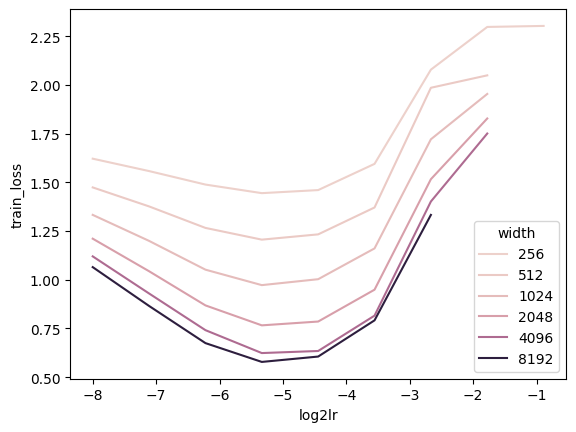

In [15]:
logs_df = pd.DataFrame(logs)
sns.lineplot(x='log2lr', y='train_loss', hue='width', data=logs_df[(logs_df['epoch']==5)])

The figure displays how model width influences training loss at various learning rates when trained with the μP method. As model width increases, training loss decreases, showcasing μP's capacity to maintain stability across different sizes, making the training process more consistent.

### Standard Parametrization (SP) Training

Now we train our model using Standard Parametrization (SP) across a variety of model widths and learning rates. Similar to the approach with μP, we systematically evaluate the impact of these hyperparameters on the SP model's training process.

We use SGD Optimizer.

**Note**: at base width, which is 256 in this case, SP and muP are completely identical.

In [16]:
logs_SP=[] # Store training results for SP models

# Loop over a predefined list of model widths
for width in list_widths:
    print(f"width = {width}")

    # Test various learning rates in log scale.
    for log2lr in np.linspace(-8, 0, 10):
        torch.manual_seed(1) # Ensure reproducibility across runs

        # Initialize the MLP model with the specified width and hyperparameters.
        mynet = MLP(width=width, nonlin=nonlin, output_mult=output_mult, input_mult=input_mult).to(device)

        # Configure the traditional SGD optimizer with the current learning rate.
        optimizer = SGD(mynet.parameters(), lr=2**log2lr)

        # Proceed to train the model for a set number of epochs.
        for epoch in range(1, epochs+1):

            # Conduct the training and retrieve the average loss
            train_loss = train(mynet, device, train_loader, optimizer, epoch, criterion=criterion)

            # Log the training results for this epoch
            logs_SP.append(dict(epoch=epoch, model_type='SP MLP', log2lr=log2lr, train_loss=train_loss, width=width,))

            # Break if the loss becomes NaN.
            if math.isnan(train_loss):
                break

width = 256


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



Train set: Average loss: 1.9597


Train set: Average loss: 1.7464


Train set: Average loss: 1.6913


Train set: Average loss: 1.6538


Train set: Average loss: 1.6212


Train set: Average loss: 1.9374


Train set: Average loss: 1.7144


Train set: Average loss: 1.6484


Train set: Average loss: 1.5995


Train set: Average loss: 1.5576


Train set: Average loss: 1.9156


Train set: Average loss: 1.6838


Train set: Average loss: 1.6027


Train set: Average loss: 1.5408


Train set: Average loss: 1.4883


Train set: Average loss: 1.9206


Train set: Average loss: 1.6730


Train set: Average loss: 1.5821


Train set: Average loss: 1.5094


Train set: Average loss: 1.4443


Train set: Average loss: 1.9433


Train set: Average loss: 1.7072


Train set: Average loss: 1.6108


Train set: Average loss: 1.5346


Train set: Average loss: 1.4600


Train set: Average loss: 2.0628


Train set: Average loss: 1.8339


Train set: Average loss: 1.7341


Train set: Average loss: 1.6592


Train set: Av

### Visualizing HP Stability

<Axes: xlabel='log2lr', ylabel='train_loss'>

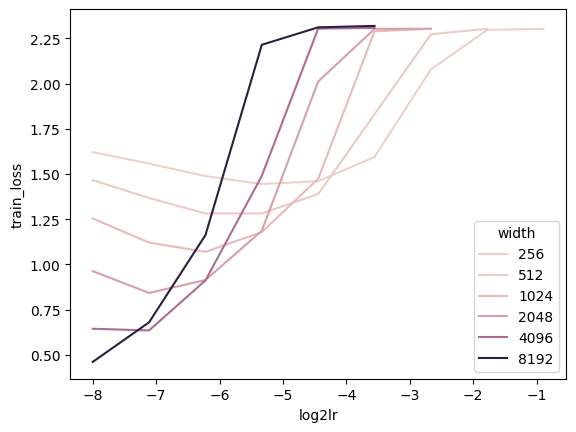

In [17]:
logs_SP_df = pd.DataFrame(logs_SP)
sns.lineplot(x='log2lr', y='train_loss', hue='width', data=logs_SP_df[(logs_SP_df['epoch']==5)])

The plot demonstrates training loss as a function of learning rate for models of various widths using standard parametrization. Unlike the μP framework, here we observe no clear pattern of stability. This variability highlights the potential challenges in model optimization without the benefits of a parameterization strategy like μP.